# DS3 Proj Step 1

# Imports and data preprocess

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.nn import init

import os
import ssl

from datetime import datetime
from random import random,randint
import math


In [2]:
incolab = False

# For colab only

In [3]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
incolab = True

Mounted at /content/drive


# Data

In [4]:
#Normalization and conversion to Tensors train and test sets

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)

#DataLoaders we are using in our algorithms
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Networks

In [53]:
class Net(nn.Module):

    model_file="models/main.pth"
  
    def __init__(self):
        super().__init__()

    def save(self, name='main',incolab=False,download=False):
        '''Helper function, use it to save the model weights after training.'''
        now = datetime.now()
        prefix = '' if incolab else './models/'
        path = f'{prefix}{now.strftime("%m-%d_%H:%M")}_{name}.pth'
        torch.save(self.state_dict(), path)
        if download :
          files.download(path)


    def load(self, model_file):
        self.load_state_dict(torch.load(model_file, map_location=torch.device(device)))

    def load_for_testing(self, project_dir='./'):
        '''This function will be called automatically before testing your
           project, and will load the model weights from the file
           specify in Net.model_file.
           You must not change the prototype of this function. You may
           add extra code in its body if you feel it is necessary, but
           beware that paths of files used in this function should be
           refered relative to the root of your project directory.
        '''        
        self.load(os.path.join(project_dir, Net.model_file))

In [54]:
# BasicNet

class BasicNet(Net):

    def __init__(self):
        super().__init__()
  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


In [55]:
# ResNet

class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.03, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if not self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 


class ResNet(Net):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.noise = GaussianNoise()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.noise(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])



class ResNetWider(Net):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetWider, self).__init__()
        self.in_planes = 80

        self.noise = GaussianNoise()
        self.conv1 = nn.Conv2d(3, 80, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(80)
        self.layer1 = self._make_layer(block, 80, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 160, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 320, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 640, num_blocks[3], stride=2)
        self.linear = nn.Linear(640*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.noise(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNetWider18():
    return ResNetWider(BasicBlock, [2,2,2,2])


In [56]:
#NoiseNet

class noise_Linear(nn.Linear):

    def __init__(self, in_features, out_features, bias=True, pni='layerwise', w_noise=True):
        super(noise_Linear, self).__init__(in_features, out_features, bias)
        
        self.pni = pni
        if self.pni is 'layerwise':
            self.alpha_w = nn.Parameter(torch.Tensor([0.25]), requires_grad = True)
        elif self.pni is 'channelwise':
            self.alpha_w = nn.Parameter(torch.ones(self.out_features).view(-1,1)*0.25,
                                        requires_grad=True)
        elif self.pni is 'elementwise':
            self.alpha_w = nn.Parameter(torch.ones(self.weight.size())*0.25, requires_grad = True)
        
        self.w_noise = w_noise

    def forward(self, input):
        
        with torch.no_grad():
            std = self.weight.std().item()
            noise = self.weight.clone().normal_(0,std)

        noise_weight = self.weight + self.alpha_w * noise * self.w_noise
        output = F.linear(input, noise_weight, self.bias)
        
        return output 



class noise_Conv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                 groups=1, bias=True, pni='layerwise', w_noise=True):
        super(noise_Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                                         padding, dilation, groups, bias)

        self.pni = pni
        if self.pni is 'layerwise':
            self.alpha_w = nn.Parameter(torch.Tensor([0.25]), requires_grad = True)
        elif self.pni is 'channelwise':
            self.alpha_w = nn.Parameter(torch.ones(self.out_channels).view(-1,1,1,1)*0.25,
                                        requires_grad = True)     
        elif self.pni is 'elementwise':
            self.alpha_w = nn.Parameter(torch.ones(self.weight.size())*0.25, requires_grad = True)  
        
        self.w_noise = w_noise    


    def forward(self, input):

        with torch.no_grad():
            std = self.weight.std().item()
            noise = self.weight.clone().normal_(0,std)

        noise_weight = self.weight + self.alpha_w * noise * self.w_noise
        output = F.conv2d(input, noise_weight, self.bias, self.stride, self.padding, self.dilation,
                        self.groups)

        return output
    
class DownsampleA(nn.Module):

    def __init__(self, nIn, nOut, stride):
      super(DownsampleA, self).__init__()
      assert stride == 2
      self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)

    def forward(self, x):
      x = self.avg(x)
      return torch.cat((x, x.mul(0)), 1)

class ResNetBasicblock(nn.Module):
  expansion = 1
  """
  RexNet basicblock (https://github.com/facebook/fb.resnet.torch/blob/master/models/resnet.lua)
  """
  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(ResNetBasicblock, self).__init__()

    self.conv_a = noise_Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn_a = nn.BatchNorm2d(planes)

    self.conv_b = noise_Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn_b = nn.BatchNorm2d(planes)

    self.downsample = downsample

  def forward(self, x):
    residual = x

    basicblock = self.conv_a(x)
    basicblock = self.bn_a(basicblock)
    basicblock = F.relu(basicblock, inplace=True)

    basicblock = self.conv_b(basicblock)
    basicblock = self.bn_b(basicblock)

    if self.downsample is not None:
      residual = self.downsample(x)
    
    return F.relu(residual + basicblock, inplace=True)

class CifarResNet(Net):
  """
  ResNet optimized for the Cifar dataset, as specified in
  https://arxiv.org/abs/1512.03385.pdf
  """
  def __init__(self, block, depth, num_classes):
    """ Constructor
    Args:
      depth: number of layers.
      num_classes: number of classes
      base_width: base width
    """
    super(CifarResNet, self).__init__()

    #Model type specifies number of layers for CIFAR-10 and CIFAR-100 model
    assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
    layer_blocks = (depth - 2) // 6
    print ('CifarResNet : Depth : {} , Layers for each block : {}'.format(depth, layer_blocks))

    self.num_classes = num_classes

    self.conv_1_3x3 = noise_Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn_1 = nn.BatchNorm2d(16)

    self.inplanes = 16
    self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
    self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
    self.stage_3 = self._make_layer(block, 64, layer_blocks, 2)
    self.avgpool = nn.AvgPool2d(8)
    self.classifier = noise_Linear(64*block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        #m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight)
        m.bias.data.zero_()

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = DownsampleA(self.inplanes, planes * block.expansion, stride)

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * block.expansion
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv_1_3x3(x)
    x = F.relu(self.bn_1(x), inplace=True)
    x = self.stage_1(x)
    x = self.stage_2(x)
    x = self.stage_3(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)

def NoiseResnet20(num_classes=10):
  model = CifarResNet(ResNetBasicblock, 20, num_classes)
  return model

def NoiseResnet32(num_classes=10):
  model = CifarResNet(ResNetBasicblock, 32, num_classes)
  return model

In [57]:
#VGGNet

class VGG(Net):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


def VGGNet11():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))

In [58]:
# BasicNet with Noise

class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if not self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

class BasicNetNoise(Net):

    def __init__(self):
        super().__init__()
  
    def __init__(self):
        super().__init__()
        self.noise = GaussianNoise()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.noise(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# Attacks

In [59]:
class Attack():

  def __init__(self, model): 
      self.model = model 

  def visualize_attack(self, trainloader, all_epsilon, alpha=None):
      #Select random image
      dataiter = iter(trainloader)
      data, targets = dataiter.next()
      
      #Begin plot construction
      plt.figure(figsize=(25,2))
      plt.subplot(191, title='normal')
      imshow(data[0])
      
      #Attacks for each epsilon
      for i, epsilon in enumerate(all_epsilon):
          plt.subplot(192+i, title='espilon %.4f:' %epsilon)
          model_copy = self.model
          model_copy.eval()
          self.model = model_copy
          perturbated_imgs = self.perturb(data, targets, epsilon, alpha=alpha)
          the_attack = perturbated_imgs[0]
          imshow(the_attack)
      
      plt.show()

In [60]:
class PGDinf_attack(Attack):

    def __init__(self, model):
        super().__init__(model)

    def perturb(self, x_natural, y, epsilon, alpha, visu=False):
        
        #Initial Predictions|
        x = x_natural.detach()
        outputs = self.model(x)
        init_pred = outputs.max(1, keepdim=True)[1]

        #Random start
        x = x + torch.zeros_like(x).uniform_(-epsilon, epsilon)
        x = torch.clamp(x, 0, 1)
        if visu :
            print(f"Original prediction : {init_pred[0].item()}")
        
        #Compute perturbations
        for i in range(10):
            x.requires_grad_()
            with torch.enable_grad():
                logits = self.model(x)
                loss = F.cross_entropy(logits, y)
            grad = torch.autograd.grad(loss, [x],
                                       retain_graph=False, create_graph=False)[0]
            x = x.detach() + alpha * torch.sign(grad.detach())
            x = torch.min(torch.max(x, x_natural - epsilon), x_natural + epsilon)
            x = torch.clamp(x, 0, 1)
        
        #Check predictions
        final_outputs = self.model(x)
        final_pred = final_outputs.max(1, keepdim=True)[1]
        if visu and init_pred[0] != final_pred[0]:
                print(f"New prediction : {final_pred[0].item()}")
        return x

In [61]:
class FGSM_attack(Attack):
    
    def __init__(self, model):
        super().__init__(model)

    def perturb(self, data, targets, epsilon=1e-3, alpha=None, visu=False):
        
        #Initial prediction 
        inputs = data.detach().clone()
        outputs = self.model(inputs)
        init_pred = outputs.max(1, keepdim=True)[1]
        if visu :
            print(f"Original prediction : {init_pred[0].item()}")
        
        #Attack + new prediction 
        self.model.zero_grad()
        inputs.requires_grad = True
        with torch.enable_grad():
            outputs = self.model(inputs)
            loss = F.nll_loss(outputs, targets)
            
        grad = torch.autograd.grad(loss, [inputs])[0] 
        perturbated_img = data.detach() + epsilon * grad.sign()
        perturbated_img = torch.clamp(perturbated_img, 0, 1) 

        #Check predictions
        final_outputs = self.model(perturbated_img)
        final_pred = final_outputs.max(1, keepdim=True)[1]
        if visu and init_pred[0] != final_pred[0]:
                print(f"New prediction : {final_pred[0].item()}")

        return perturbated_img #, init_pred.item(), new_pred.item()
    

In [62]:
class PGDl2_attack(Attack):

    def __init__(self, model):
        super().__init__(model)

    def perturb(self, x_natural, y, epsilon, alpha, visu=False):
        
        # scale params by by 30 for comparison purpose

        epsilon *= 30
        alpha *= 30
        
        #Initial Predictions

        x = x_natural.detach()
        batch_size = len(x)
        outputs = self.model(x)
        init_pred = outputs.max(1, keepdim=True)[1]

        # Random start

        delta = torch.empty_like(x).normal_()
        d_flat = delta.view(x.size(0),-1)
        n = d_flat.norm(p=2,dim=1).view(x.size(0),1,1,1)
        r = torch.zeros_like(n).uniform_(0, 1)
        delta *= r/n*epsilon

        if visu :
            print(f"Original prediction : {init_pred[0].item()}")
        
        #Compute perturbations
        for i in range(10):
            x.requires_grad_()
            with torch.enable_grad():
                logits = self.model(x)
                loss = F.cross_entropy(logits, y)
            grad = torch.autograd.grad(loss, [x],
                                       retain_graph=False, create_graph=False)[0]
            grad_norms = torch.linalg.norm(grad.view(batch_size, -1), dim=1) + 1e-10 
            grad = grad / grad_norms.view(batch_size, 1, 1, 1) 
            x_adv = x.detach() + alpha * grad

            delta = x_adv - x
            delta_norms = torch.linalg.norm(delta.view(batch_size, -1), dim=1)
            factor = epsilon / delta_norms
            # factor = torch.min(factor, torch.ones_like(delta_norms)) # Seem to limit heavily the perturbation
            delta = delta * factor.view(-1, 1, 1, 1)

            x_adv = torch.clamp(x + delta, 0, 1).detach()

        
        #Check predictions
        final_outputs = self.model(x_adv)
        final_pred = final_outputs.max(1, keepdim=True)[1]
        if visu and init_pred[0] != final_pred[0]:
                print(f"New prediction : {final_pred[0].item()}")
        return x_adv

In [63]:
class CW(Attack):
    r"""
    CW in the paper 'Towards Evaluating the Robustness of Neural Networks'
    [https://arxiv.org/abs/1608.04644]
    Distance Measure : L2
    Arguments:
        model (nn.Module): model to attack.
        c (float): c in the paper. parameter for box-constraint. (Default: 1e-4)    
            :math:`minimize \Vert\frac{1}{2}(tanh(w)+1)-x\Vert^2_2+c\cdot f(\frac{1}{2}(tanh(w)+1))`
        kappa (float): kappa (also written as 'confidence') in the paper. (Default: 0)
            :math:`f(x')=max(max\{Z(x')_i:i\neq t\} -Z(x')_t, - \kappa)`
        steps (int): number of steps. (Default: 1000)
        lr (float): learning rate of the Adam optimizer. (Default: 0.01)
    .. warning:: With default c, you can't easily get adversarial images. Set higher c like 1.
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.CW(model, c=1e-4, kappa=0, steps=1000, lr=0.01)
        >>> adv_images = attack(images, labels)
    .. note:: Binary search for c is NOT IMPLEMENTED methods in the paper due to time consuming.
    """
    def __init__(self, model, c=1e-4, kappa=0, steps=1000, lr=0.01):
        super().__init__(model)
        self.c = c
        self.kappa = kappa
        self.steps = steps
        self.lr = lr
        self._supported_mode = ['default', 'targeted']

    def perturb(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(device)
        labels = labels.clone().detach().to(device)

        # w = torch.zeros_like(images).detach() # Requires 2x times
        w = self.inverse_tanh_space(images).detach()
        w.requires_grad = True

        best_adv_images = images.clone().detach()
        best_L2 = 1e10*torch.ones((len(images))).to(device)
        prev_cost = 1e10
        dim = len(images.shape)

        MSELoss = nn.MSELoss(reduction='none')
        Flatten = nn.Flatten()

        optimizer = optim.Adam([w], lr=self.lr)

        for step in range(self.steps):
            # Get adversarial images
            adv_images = self.tanh_space(w)

            # Calculate loss
            current_L2 = MSELoss(Flatten(adv_images),
                                 Flatten(images)).sum(dim=1)
            L2_loss = current_L2.sum()

            outputs = self.model(adv_images)
            f_loss = self.f(outputs, labels).sum()

            cost = L2_loss + self.c*f_loss

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            # Update adversarial images
            _, pre = torch.max(outputs.detach(), 1)
            correct = (pre == labels).float()

            # filter out images that get either correct predictions or non-decreasing loss, 
            # i.e., only images that are both misclassified and loss-decreasing are left 
            mask = (1-correct)*(best_L2 > current_L2.detach())
            best_L2 = mask*current_L2.detach() + (1-mask)*best_L2

            mask = mask.view([-1]+[1]*(dim-1))
            best_adv_images = mask*adv_images.detach() + (1-mask)*best_adv_images

            # Early stop when loss does not converge.
            if step % (self.steps//10) == 0:
                if cost.item() > prev_cost:
                    return best_adv_images
                prev_cost = cost.item()

        return best_adv_images

    def tanh_space(self, x):
        return 1/2*(torch.tanh(x) + 1)

    def inverse_tanh_space(self, x):
        # torch.atanh is only for torch >= 1.7.0
        return self.atanh(x*2-1)

    def atanh(self, x):
        return 0.5*torch.log((1+x)/(1-x))

    # f-function in the paper
    def f(self, outputs, labels):
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1) # get the second largest logit
        j = torch.masked_select(outputs, one_hot_labels.bool()) # get the largest logit
        
        torch.clamp((j-i), min=-self.kappa)

In [64]:
# visu_adversary = CW(visu_net)
# dataiter = iter(trainloader)
# data, targets = dataiter.next()
# data = data.detach().to(device)
# targets = targets.detach().to(device)
# visu_adversary.perturb(data, targets)

In [65]:
# |visu_alpha = 0.007
# visu_epsilons = np.logspace(-4,1,6)
# visu_net = BasicNet()
# visu_adversary = CW(visu_net)
# imshow(visu_adversary)

# Train test save utility functions

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def adjust_learning_rate(optimizer, epoch, learning_rate, threshold1, threshold2):
    if epoch == threshold1 or epoch == threshold2:
        lr = learning_rate
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [87]:
def plot_history(history,incolab = False, download=False):

    now = datetime.now()

    k = np.linspace(1,epochs,epochs)
    acc = list(history.keys())
    colors = iter(cm.rainbow(np.linspace(0, 1, len(acc))))
    plt.figure(figsize=(10, 5))

    for e in acc :
        color = next(colors)
        plt.plot(k, history[e], label=f'{e} accuracy',color=color)

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Learning curve", fontsize=16)
    plt.legend(loc="lower right")
    
    prefix = '' if incolab else './figures/'
    f_name = f'{prefix}{now.strftime("%m-%d_%H:%M")}_adv_learning_curve.jpg'
    plt.savefig(f_name)
    if download:
      files.download(f_name)

    plt.show()
    
def save_history(history,incolab = False, download=False):
    
    now = datetime.now()
    
    prefix = '' if incolab else './histories/'
    path = f'{prefix}{now.strftime("%m-%d_%H:%M")}_adv_history.csv'

    df = pd.DataFrame(history)
    df.to_csv(path,index=False)
    if download:
      files.download(path)

In [88]:
r = random()
print(r)
0.1<=0.3

0.028283706776100592


True

In [89]:
def train(model, defense, train_loader, criterion, optimizer, epsilon, alpha=None):
  
  model.train()
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(train_loader):
      
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()

      mix1= 0.95
      #mix2= 0.15
      
      if defense == 'manual':
        r = random()
        if r <= mix1:
            perturbated_imgs = PGDinf_attack(model).perturb(inputs, targets, epsilon, alpha=alpha)
            outputs = model(perturbated_imgs)
        # elif mix1 < r < mix1 + mix2:
        #     perturbated_imgs = PGDl2_attack(model).perturb(inputs, targets, epsilon, alpha=alpha)
        #     outputs = model(perturbated_imgs)
        else:
            outputs = model(inputs)
      
      elif type(defense) is list :
            d = randint(0, len(defense)-1)
            perturbated_imgs = defense[d](model).perturb(inputs, targets, epsilon, alpha=alpha) 
            outputs = model(perturbated_imgs)
      
      elif defense is not None :
            perturbated_imgs = defense(model).perturb(inputs, targets, epsilon, alpha=alpha)  
            outputs = model(perturbated_imgs)

      else:
          outputs = model(inputs)

      loss = criterion(outputs, targets)
      loss.backward()

      optimizer.step()
      train_loss+=loss.item()
      _, predicted = outputs.max(1) 

      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  train_acc = 100. * correct / total
  print('\nFinal normal ongoing training accuracy :', train_acc)

  return train_acc

def test(model, attack, test_loader, criterion, epsilon, alpha=None,verbose=True):
    model.eval()
    normal_loss = 0
    adv_loss = 0
    normal_correct = 0
    adv_correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):

            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            normal_loss += loss.item()

            # Natural accuracy

            _, predicted = outputs.max(1)
            normal_correct += predicted.eq(targets).sum().item()

            # Adversarial accuracy

            perturbated_img = attack(model).perturb(inputs, targets, epsilon, alpha=alpha)
            perturbated_outputs = model(perturbated_img)
            loss = criterion(perturbated_outputs, targets)
            adv_loss += loss.item()

            _, predicted = perturbated_outputs.max(1)
            adv_correct += predicted.eq(targets).sum().item()

            test_acc = 100. * normal_correct / total
            test_adv_acc = 100. * adv_correct / total
    
    if verbose:
      print('Final normal test accuracy:', test_acc)
      print('Final adversarial test Accuracy:', test_adv_acc)

    return test_acc, test_adv_acc
    

In [90]:
def train_test_save(model, epochs, train_loader, test_loader, criterion, optimizer, epsilon, 
          alpha=None, attack = PGDinf_attack, defense = None, lrthreshold1=15, lrthreshold2=25):

    history = {'train':[], 'test':[], 'test_adv':[]}
    
    for epoch in range(epochs):

        #Train
        
        print('\n[ Train epoch: %d ]' % (epoch+1))

        adjust_learning_rate(optimizer, epoch,learning_rate,lrthreshold1, lrthreshold2) 
        train_acc = train(model, defense, train_loader, criterion, optimizer, epsilon, alpha)
        history["train"].append(train_acc)

        #Test

        test_acc, test_adv_acc = test(model, attack, testloader, criterion, epsilon, alpha)
        history['test'].append(test_acc)
        history['test_adv'].append(test_adv_acc)

        #Save
        
        if epoch % 5 == 0:
            model_type = 'adv' if defense is not None else 'naive'

            model.module.save(name=f'{model_type}_{str(epoch)}',incolab=incolab)
            save_history(history,incolab=incolab)
    
    return history,model

# Main training function

In [91]:
def get_trained_network (network,epochs,epsilon, learning_rate,train_loader = trainloader, test_loader = testloader,alpha=None,attack = PGDinf_attack, defense = None,load=False,lrthreshold1=100, lrthreshold2=150):

  My_net = network().to(device)
  My_net = torch.nn.DataParallel(My_net)
  cudnn.benchmark = True

  adv = attack(My_net)
  CE_loss = nn.CrossEntropyLoss()
  sgd_optimizer = optim.SGD(My_net.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0.0002)

  # Load if relevant 
  path= '/content/drive/My Drive/work/Projet 3 DS/' if incolab else './'

  if load :
    try :
      My_net.module.load_for_testing(project_dir=path) 
    except :
      print('failed')
      pass

  history, trained_model = train_test_save(My_net, epochs, train_loader, test_loader, CE_loss, sgd_optimizer, epsilon, 
          alpha, attack, defense,lrthreshold1=lrthreshold1, lrthreshold2=lrthreshold2)

  return history,trained_model

# Plot attacks

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     #Unormalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

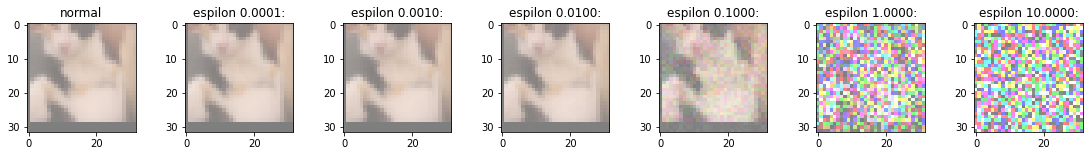

In [ ]:
visu_alpha = 0.007
visu_epsilons = np.logspace(-4,1,6)
visu_net = BasicNet()
visu_adversary = PGDinf_attack(visu_net)
visu_adversary.visualize_attack(trainloader, visu_epsilons, alpha=visu_alpha)

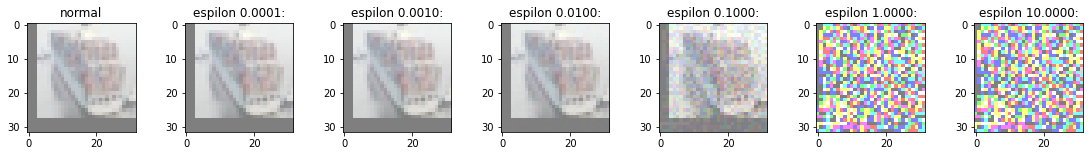

In [ ]:
visu_epsilons = np.logspace(-4,1,6)
visu_net = BasicNet()
visu_adversary = FGSM_attack(visu_net)
visu_adversary.visualize_attack(trainloader, visu_epsilons)

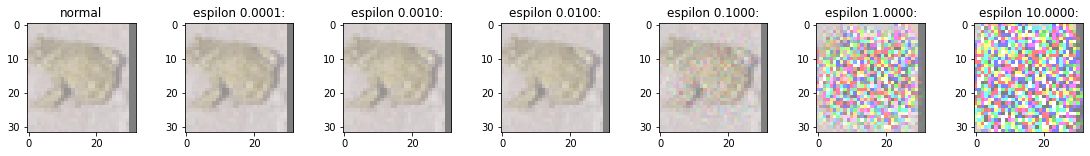

In [ ]:
visu_alpha = 0.2
visu_epsilons = np.logspace(-4,1,6)
visu_net = BasicNet()
visu_adversary = PGDl2_attack(visu_net)
visu_adversary.visualize_attack(trainloader, visu_epsilons, alpha=visu_alpha)

# BasicNet training

## Attacks on Naive model

In [ ]:
epochs= 40
learning_rate = 0.01
epsilon = 0.03
alpha = 2/255

In [ ]:
history,basic_nat_pgdinf = get_trained_network(BasicNet,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDinf_attack, defense = None,load=False)

In [ ]:
basic_nat_pgdinf.model.module.save(name='basic_nat_pgdinf',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

In [ ]:
learning_rate = 0.001
epochs = 50
epsilon = 0.03

In [ ]:
history, basic_nat_fgsm = get_trained_network(BasicNet,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = FGSM_attack defense = None,load=False)

In [ ]:
basic_nat_fgsm.model.module.save(name='basic_nat_pgdinf',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

## PGDinf training

In [ ]:
epochs= 10
learning_rate = 0.01
epsilon = 0.03
alpha = 2/255

In [ ]:
history,basic_adv_pgdinf = get_trained_network(BasicNet,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDinf_attack, defense = PGDinf_attack,load=False)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 7.186
Final normal test accuracy: 13.17
Final adversarial test Accuracy: 3.95

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 9.998
Final normal test accuracy: 13.98
Final adversarial test Accuracy: 13.23

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 14.642
Final normal test accuracy: 20.88
Final adversarial test Accuracy: 18.44

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 18.206
Final normal test accuracy: 25.53
Final adversarial test Accuracy: 20.4

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 19.786
Final normal test accuracy: 27.77
Final adversarial test Accuracy: 22.15

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 20.564
Final normal test accuracy: 28.56
Final adversarial test Accuracy: 21.62

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 21.052
Final normal test accuracy: 31.93
Final adversarial test Accuracy: 23.5

[ Train ep

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

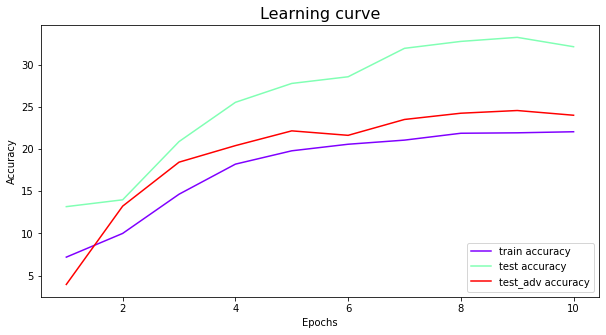

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
basic_adv_pgdinf.module.save(name='basic_adv_pgdinf',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

## PGDl2 training

In [ ]:
epochs= 10
learning_rate = 0.01
epsilon = 0.03
alpha = 0.2

In [ ]:
history,basic_adv_pgdl2 = get_trained_network(BasicNet,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDl2_attack, defense = PGDl2_attack,load=False)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 11.108
Final normal test accuracy: 19.2
Final adversarial test Accuracy: 16.09

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 15.994
Final normal test accuracy: 20.71
Final adversarial test Accuracy: 16.82

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 18.474
Final normal test accuracy: 26.92
Final adversarial test Accuracy: 20.24

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 20.594
Final normal test accuracy: 31.75
Final adversarial test Accuracy: 23.52

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 21.952
Final normal test accuracy: 33.95
Final adversarial test Accuracy: 24.21

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 22.418
Final normal test accuracy: 36.68
Final adversarial test Accuracy: 25.28

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 23.354
Final normal test accuracy: 35.52
Final adversarial test Accuracy: 24.22

[ Trai

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

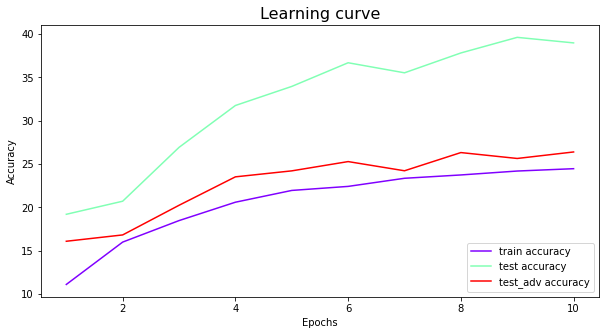

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
basic_adv_pgdl2.module.save(name='basic_adv_pgdl2',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

## FGSM training

In [ ]:
learning_rate = 0.001
epochs = 3
epsilon = 0.03

In [ ]:
history,basic_adv_fgsm = get_trained_network(BasicNet,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha=None,attack = FGSM_attack, defense = FGSM_attack,load=False)

In [ ]:
basic_adv_fgsm.module.save(name='basic_adv_fgsm',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

## Mixed pgd training

In [ ]:
epochs= 10
learning_rate = 0.01
epsilon = 0.03
alpha = 2/255

In [ ]:
history,basic_adv_pgdl2 = get_trained_network(BasicNet,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDinf_attack, defense = [PGDinf_attack,PGDl2_attack],load=False)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 9.916
Final normal test accuracy: 13.52
Final adversarial test Accuracy: 11.54

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 14.786
Final normal test accuracy: 20.62
Final adversarial test Accuracy: 17.47

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 17.71
Final normal test accuracy: 25.61
Final adversarial test Accuracy: 20.42

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 19.262
Final normal test accuracy: 28.58
Final adversarial test Accuracy: 21.65

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 20.17
Final normal test accuracy: 30.03
Final adversarial test Accuracy: 22.46

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 21.122
Final normal test accuracy: 32.17
Final adversarial test Accuracy: 22.93

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 21.418
Final normal test accuracy: 35.06
Final adversarial test Accuracy: 24.23

[ Train 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

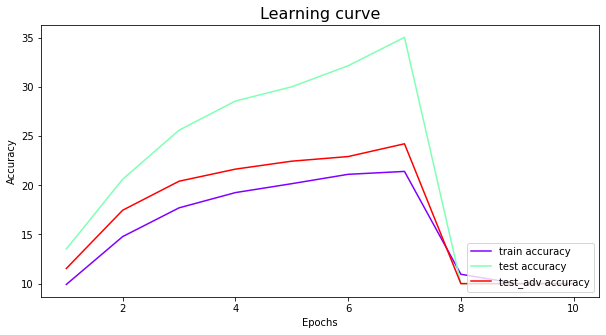

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
basic_adv_pgdl2.module.save(name='basic_adv_pgdl2',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

# ResNet

In [92]:
# Hyperparams

epochs= 5
learning_rate = 0.01
epsilon = 0.03
alpha = 0.0075

In [93]:
history,resnetwide18_mix_inf = get_trained_network(ResNetWider18,epochs,epsilon, learning_rate, alpha = alpha,attack = PGDinf_attack, defense = 'manual',load=True,lrthreshold1=29, lrthreshold2=33)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 60.59
Final normal test accuracy: 80.15
Final adversarial test Accuracy: 52.37

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 61.848
Final normal test accuracy: 80.11
Final adversarial test Accuracy: 51.58

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 61.764
Final normal test accuracy: 80.34
Final adversarial test Accuracy: 50.85

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 62.618
Final normal test accuracy: 80.81
Final adversarial test Accuracy: 51.78

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 62.496
Final normal test accuracy: 79.52
Final adversarial test Accuracy: 51.3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

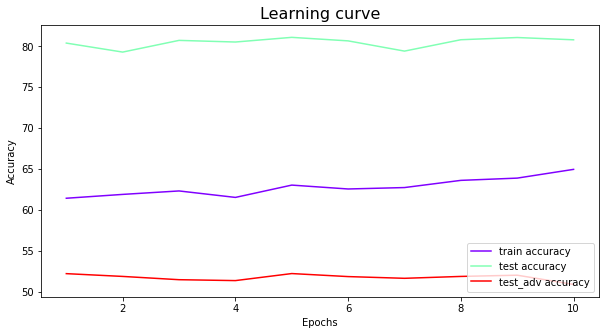

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
resnetwide18_mix_inf.module.save(name='resnetwider18_mix_inf_35',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

In [ ]:
# PGDinf
history,resnet18_adv_pgdinf = get_trained_network(ResNet18,epochs,epsilon, learning_rate, alpha = alpha,attack = PGDinf_attack, defense = PGDinf_attack,load=False,lrthreshold1=25, lrthreshold2=40)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 17.032
Final normal test accuracy: 30.54
Final adversarial test Accuracy: 24.29

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 23.606
Final normal test accuracy: 35.89
Final adversarial test Accuracy: 27.47

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 26.214
Final normal test accuracy: 40.59
Final adversarial test Accuracy: 26.91

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 28.78
Final normal test accuracy: 43.92
Final adversarial test Accuracy: 29.89

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 30.662
Final normal test accuracy: 48.28
Final adversarial test Accuracy: 31.25

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 32.462
Final normal test accuracy: 51.13
Final adversarial test Accuracy: 32.67

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 34.202
Final normal test accuracy: 51.7
Final adversarial test Accuracy: 33.9

[ Train 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

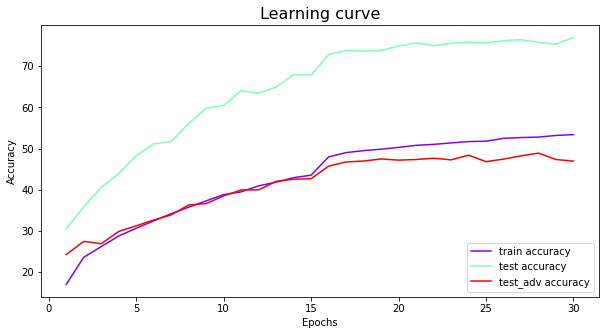

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
resnet18_adv_pgdinf.module.save(name='resnet18_adv_pgdinf',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

In [ ]:
# Mixed 

history,resnet18_advmixed_pgdinf = get_trained_network(ResNet18,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDinf_attack, defense = 'manual',load=False,lrthreshold1=30, lrthreshold2=40)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 16.8
Final normal test accuracy: 27.58
Final adversarial test Accuracy: 20.57

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 23.91
Final normal test accuracy: 38.28
Final adversarial test Accuracy: 24.9

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 26.672
Final normal test accuracy: 41.67
Final adversarial test Accuracy: 28.65

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 28.876
Final normal test accuracy: 45.44
Final adversarial test Accuracy: 31.39

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 31.05
Final normal test accuracy: 48.92
Final adversarial test Accuracy: 32.76

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 33.25
Final normal test accuracy: 51.55
Final adversarial test Accuracy: 33.24

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 34.644
Final normal test accuracy: 55.98
Final adversarial test Accuracy: 35.22

[ Train epo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

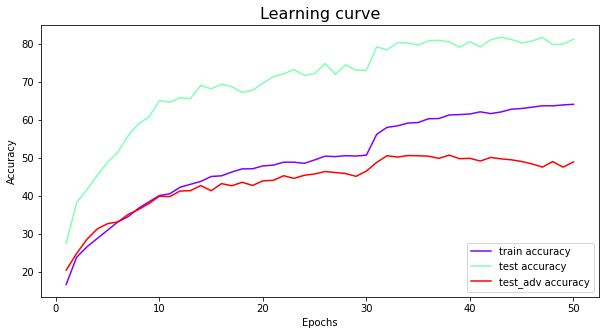

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history,resnet18_advmixed_pgdinf.module.save(name='resnet18_advmixed_pgdinf',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

In [ ]:
CE_loss = nn.CrossEntropyLoss()

nat,adv = test(resnet20_advmixed_pgdinf, PGDl2_attack, testloader, CE_loss, epsilon = 0.03,alpha = 0.0075,verbose=False)
print(nat,adv)

70.55 48.1


In [ ]:
history,resnet20_advmixed_pgdinf = get_trained_network(ResNet20,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDinf_attack, defense = [PGDinf_attack,PGDl2_attack],load=False,lrthreshold1=30, lrthreshold2=40)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 17.614
Final normal test accuracy: 33.1
Final adversarial test Accuracy: 23.46

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 23.774
Final normal test accuracy: 36.54
Final adversarial test Accuracy: 23.75

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 26.504
Final normal test accuracy: 42.45
Final adversarial test Accuracy: 25.55

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 28.666
Final normal test accuracy: 45.63
Final adversarial test Accuracy: 27.47

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 30.752
Final normal test accuracy: 49.89
Final adversarial test Accuracy: 30.92

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 32.23
Final normal test accuracy: 52.47
Final adversarial test Accuracy: 30.9

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 33.352
Final normal test accuracy: 54.37
Final adversarial test Accuracy: 32.27

[ Train 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

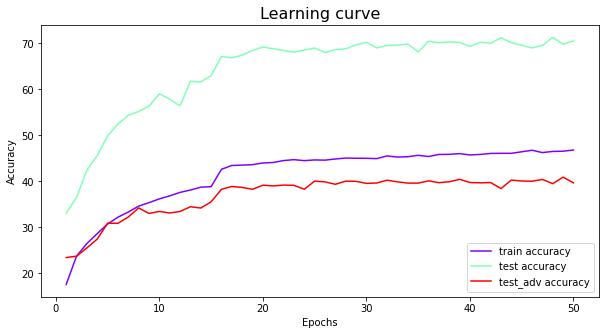

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history,resnet20_advmixed_pgdinf.module.save(name='resnet20_advmixed_pgdinf',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

# VGG

In [ ]:
history,vgg11_mix_inf = get_trained_network(VGGNet11,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDinf_attack, defense = [PGDinf_attack,PGDl2_attack],load=False,lrthreshold1=30, lrthreshold2=40)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 18.128
Final normal test accuracy: 27.87
Final adversarial test Accuracy: 20.99

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 22.278
Final normal test accuracy: 31.84
Final adversarial test Accuracy: 21.97

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 23.966
Final normal test accuracy: 38.52
Final adversarial test Accuracy: 27.88

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 26.188
Final normal test accuracy: 42.97
Final adversarial test Accuracy: 26.88

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 29.154
Final normal test accuracy: 46.85
Final adversarial test Accuracy: 30.19

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 30.732
Final normal test accuracy: 50.37
Final adversarial test Accuracy: 30.05

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 32.696
Final normal test accuracy: 52.58
Final adversarial test Accuracy: 32.95

[ Tra

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

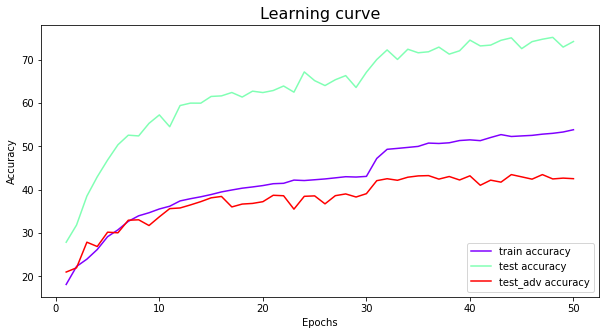

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history,vgg11_mix_inf.module.save(name='vgg11_mix_inf_50',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

In [ ]:
nat,adv = test(vgg11_mix_inf, PGDl2_attack, testloader, CE_loss, epsilon = 0.03,alpha = 0.0075,verbose=False)
print(nat,adv)
nat,adv = test(vgg11_mix_inf, FGSM_attack, testloader, CE_loss, epsilon = 0.03,alpha = None,verbose=False)
print(nat,adv)

74.2 52.54
74.2 57.24


# NoiseNet

In [ ]:
# Hyperparams

epochs= 100
learning_rate = 0.1
epsilon = 0.03
alpha = 0.0075

In [ ]:
# PGDinf

history,noisenet20_pgdinf_pgdinf = get_trained_network(NoiseResnet20,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDinf_attack, defense = [PGDinf_attack,PGDl2_attack],load=False)

CifarResNet : Depth : 20 , Layers for each block : 3

[ Train epoch: 1 ]

Final normal ongoing training accuracy : 21.11
Final normal test accuracy: 30.34
Final adversarial test Accuracy: 22.56

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 26.008
Final normal test accuracy: 38.16
Final adversarial test Accuracy: 25.53

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 28.518
Final normal test accuracy: 42.93
Final adversarial test Accuracy: 28.54

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 30.262
Final normal test accuracy: 48.09
Final adversarial test Accuracy: 28.47

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 32.008
Final normal test accuracy: 48.63
Final adversarial test Accuracy: 29.99

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 33.436
Final normal test accuracy: 47.67
Final adversarial test Accuracy: 31.32

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 34.586
Final normal test accuracy:

KeyboardInterrupt: ignored

In [ ]:
noisenet20_pgdinf_pgdinf.module.save(name=f'noisenet20_mix_inf_{epochs}',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

# BasicNetNoise

In [ ]:
# Hyperparams

epochs=100
learning_rate = 0.001
epsilon = 0.03
alpha = 2/255

In [ ]:
# PGDinf
history,basicnetnoise_adv_pgdinf = get_trained_network(BasicNetNoise,epochs,epsilon, learning_rate, alpha = alpha,attack = PGDinf_attack, defense = PGDinf_attack,load=False,lrthreshold1=60, lrthreshold2=80)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 10.0
Final normal test accuracy: 10.0
Final adversarial test Accuracy: 10.0

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 9.818
Final normal test accuracy: 11.46
Final adversarial test Accuracy: 10.21

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 6.034
Final normal test accuracy: 15.34
Final adversarial test Accuracy: 7.53

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 7.068
Final normal test accuracy: 12.74
Final adversarial test Accuracy: 8.98

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 9.046
Final normal test accuracy: 13.05
Final adversarial test Accuracy: 10.86

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 9.574
Final normal test accuracy: 11.68
Final adversarial test Accuracy: 10.25

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 9.93
Final normal test accuracy: 13.18
Final adversarial test Accuracy: 10.76

[ Train epoch: 8 ]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

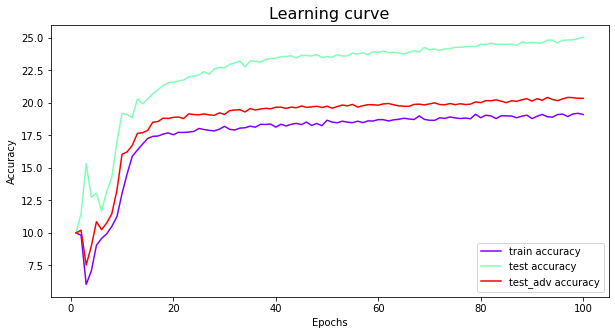

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
basicnetnoise_adv_pgdinf.module.save(name=f'basicnetnoise_adv_pgdinf_{epochs}',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

In [ ]:
# PGDinf
history,basicnet_adv_pgdinf = get_trained_network(BasicNet,epochs,epsilon, learning_rate, alpha = alpha,attack = PGDinf_attack, defense = PGDinf_attack,load=False,lrthreshold1=60, lrthreshold2=80)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 10.0
Final normal test accuracy: 10.0
Final adversarial test Accuracy: 10.0

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 9.998
Final normal test accuracy: 10.0
Final adversarial test Accuracy: 10.0

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 9.998
Final normal test accuracy: 10.0
Final adversarial test Accuracy: 9.94

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 6.312
Final normal test accuracy: 10.02
Final adversarial test Accuracy: 9.88

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 8.662
Final normal test accuracy: 12.49
Final adversarial test Accuracy: 7.72

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 4.234
Final normal test accuracy: 15.84
Final adversarial test Accuracy: 6.43

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 5.632
Final normal test accuracy: 15.83
Final adversarial test Accuracy: 8.38

[ Train epoch: 8 ]

Fin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

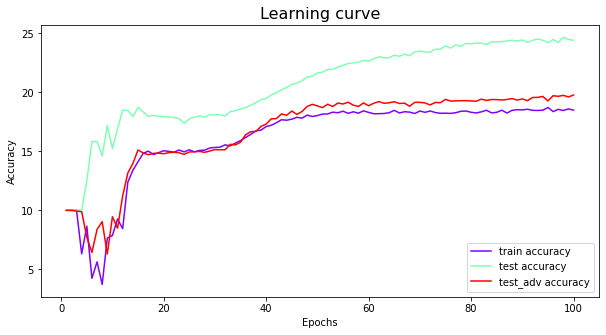

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
basicnet_adv_pgdinf.module.save(name=f'basicnet_adv_pgdinf_{epochs}',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

# Tests

In [96]:
network = ResNetWider18()

mynet = network.to(device)
mynet = torch.nn.DataParallel(mynet)
cudnn.benchmark = True

mynet.module.load('/content/drive/My Drive/work/Projet 3 DS/models/main.pth')
CE_loss = nn.CrossEntropyLoss()

nat,adv = test(mynet, PGDl2_attack, testloader, CE_loss, epsilon = 0.03,alpha = 0.0075,verbose=False)
print(nat,adv)
nat,adv = test(mynet, FGSM_attack, testloader, CE_loss, epsilon = 0.03,alpha = None,verbose=False)
print(nat,adv)
nat,adv = test(mynet, PGDinf_attack, testloader, CE_loss, epsilon = 0.03,alpha = 0.0075,verbose=False)
print(nat,adv)

80.37 56.0
80.33 65.33
80.38 52.34


In [97]:
from torchsummary import summary
model = ResNetWider18().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     GaussianNoise-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 80, 32, 32]           2,160
       BatchNorm2d-3           [-1, 80, 32, 32]             160
            Conv2d-4           [-1, 80, 32, 32]          57,600
       BatchNorm2d-5           [-1, 80, 32, 32]             160
            Conv2d-6           [-1, 80, 32, 32]          57,600
       BatchNorm2d-7           [-1, 80, 32, 32]             160
        BasicBlock-8           [-1, 80, 32, 32]               0
            Conv2d-9           [-1, 80, 32, 32]          57,600
      BatchNorm2d-10           [-1, 80, 32, 32]             160
           Conv2d-11           [-1, 80, 32, 32]          57,600
      BatchNorm2d-12           [-1, 80, 32, 32]             160
       BasicBlock-13           [-1, 80, 32, 32]               0
           Conv2d-14          [-1, 160,